# CCD-detektor jegyzőkönyv

## A mérés előkészítése

Az alábbi képen látható a mérésben használt CCD-kamera a rászerelt optikával és szűrőváltó tárcsával. A mérési utasításban kért szűrőt, takarást vagy szűrő nélküli állást a képen látható csavar meglazítása után tudja kiválasztani. A teljes takarásnál a takaró kupakot óvatosan kell kihúzni, hogy a tárcsa forgatható legyen. A megfelelő ablak beállítása után a csavarral rögzítse a váltót.
<img src="supplementary/CCD.png" alt="CCD">


A kamera- és a termosztátvezérlés az alábbi képen látható.
<img src="supplementary/CCD_proc.png" alt="CCD elektronika">
A műszerdoboz elején található a bekapcsoló gomb, a hátlap jobb felső részén a reset nyomógomb található.


Annak érdekében, hogy a notebookból lehessen a mérést vezérelni először egy IP tunnelt kell felépíteni ssh parancs segítségével a **mérőgépről**.

```bash
    $ cp /labor/ccd/tunnel0_rsa .
    $ chmod 400 tunnel0_rsa
    $ ssh -i tunnel0_rsa tunnel0@itl84.elte.hu
```

Miután felépült a csatorna, kapcsolja be az SBIG ST-5 CCD-kamera vezérlőegységét, és a **mérőgépen** egy újabb terminálablakban indítsa el a kamera vezérlését hálózatra átjátszó proxy-programot a következő paranccsal:

```bash
    $ cd /labor/ccd/
    $ ./server.sh
```

A parancs futtatása után a program kiírja a képernyőre a CCD-kamera aktuális állapotát, és a gyorsabb adatátvitelhez az alapértelmezett sorosvonali sebességet megnöveli. 

A következő néhány cella lefuttatásával kapcsolódjon a kameravezérléshez. Amennyiben a csatlakozás néhány másodpercen belül sikertelen, úgy végezze el az alábbi lépéseket:

* A Kernel/Interrupt paranccsal szakítsa meg a jupyter futásását,
* Ctrl+C-vel lépjen ki a szerverprogramomból,
* a reset gomb megnyomásával indítsa újra a CCD-kamera vezérlőegységét,
* indítsa újra a szerverprogramot,
* példányosítsa újra a notebookban futó kliens oldali ST5 osztályt, és futtassa újra az `ST5.open()` metódust..

Ügyeljen arra, hogy a kamera műveleiteinek megszakítása (interrupt kernel) a kamera újraindítását igényelheti! 

Ügyeljen arra, hogy a jegyzőköny adatai a cellák újrafuttatásakor elveszhetnek. A mért adatokat mindig mentse arra alkalmas formátumban, kerülve a veszteséges tömörítési eljárásokat!

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import sys
import time
import sbigpy
import scipy.optimize

In [3]:
st5 = sbigpy.ST5("tcp://157.181.168.84:3333")
st5.open()

In [4]:
st5.print_status()

ROM version: v2.1
CPU version: 1
CPU: 1
Firmware version: 258
Name: SBIG ST-5 CCD Camera            
Shutter: 0
Needs offset: 0
DCS: 0
DCR: 0
Temp control supported: 1
Max TE drive: 1900
Image width: 320
Image height: 240
Read out modes:
--- Mode 0: ---
Mode: 0
Width: 320
Height: 240
Gain: 352
Pixel width: 4096
Pixel height: 4096
--- Mode 1: ---
Mode: 1
Width: 160
Height: 120
Gain: 800
Pixel width: 8192
Pixel height: 8192
--- -------- ---
Temp control enabled: 0
Temp setpoint: 0
Temp output drive: 0
Temp sample rate: 10
Temp p_gain: 1000
Temp i_gain: 164
Temp brownout detected: 0
Temperature: 22.713270 °C


A termosztát bekapcsolása és a célhőmérséklet beállítása az `st5.set_temperature(celsius)` függvény segítségével történik, a termosztát kikapcsolására pedig az `st5.reset_temperature()` függvény szolgál. 

A kapcsolatfelépítés után kikapcsoljuk a hűtést.

In [5]:
st5.reset_temperature()

## 1. feladat: a CCD termosztátjának vizsgálata

### 1. a) - 5 pont

Az kamera detektorának °C egységekben mért aktuális hőmérsékletét az `st5.get_temperature()` függvénnyel olvashatja ki. 

Írjon egy rövid python scriptet, mely rövid időn keresztül, másodpercenkénti felbontással kiolvassa a kamera termisztorát! 

Várja meg, amíg a termosztát hőmérséklete közel állandó nem lesz.

Készítsen ábrát a mérésről! Az egy másodperces várakozáshoz használja a `time.sleep(sec)` függvényt!

In [6]:
# Hőmérséklet kiolvasása
st5.get_temperature()

22.713269747890674

In [1]:
# Mintavételezés
def hőm(minta):
    T=[]
    t=linspace(0,minta-1,minta)
    for i in range(minta):
        T.append(st5.get_temperature())
        time.sleep(1)
    T=array(T)
    return t,T


In [2]:
ido ,result = hőm(30)

NameError: name 'linspace' is not defined

In [26]:
#savetxt("elso.txt",result)
with open('elso.txt', 'r') as file:
    result = file.read()
    result = result.split("\n")

result = [float(element) for element in result if element]
result = array(result)
ido = np.linspace(0,29,30)

Text(0.5, 1.0, 'A termosztát vizsgálata')

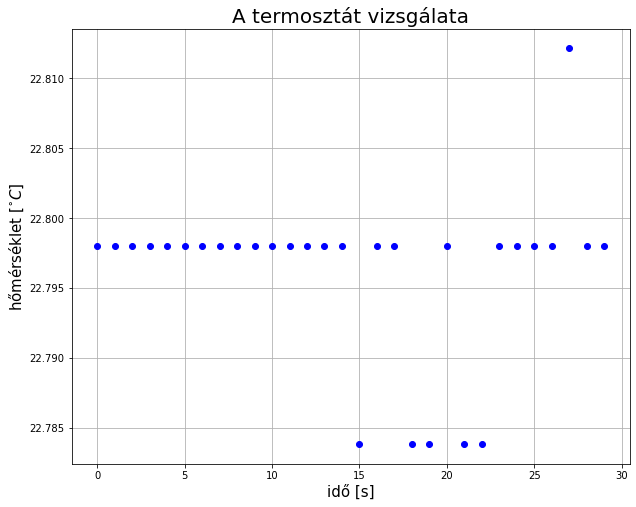

In [27]:
# Ábrarajzolás
figsize(10,8)
plot(ido,result, "bo")
grid()
xlabel("idő [s]", size = 15)
ylabel(r"hőmérséklet [$^{\circ} C$]", size = 15)
title("A termosztát vizsgálata", size = 20)

In [28]:
diff = result[1:]-result[:-1]

In [29]:
diff

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.01412975,
        0.01412975,  0.        , -0.01412975,  0.        ,  0.01412975,
       -0.01412975,  0.        ,  0.01412975,  0.        ,  0.        ,
        0.        ,  0.01413387, -0.01413387,  0.        ])

### 1. b) - 3 pont

Hűtse le a CCD-t -5 °C-ra! A hűtési folyamat során folyamatosan olvassa ki a termiszor pillanatnyi értékét! Ábrázolja a hőmérséklet változását a hűtési folyamat során! Mennyi idő elteltével tekinthető megfelelően stabilnak a detektor hőmérséklete? A hűtési folyamat milyen jellegzetessége figyelhető meg? Mi lehet ennek az oka?

In [21]:
# mérés
def cool(minta):
    T=[]
    t=linspace(0,minta-1,minta)
    st5.set_temperature(-5)
    for i in range(minta):
        T.append(st5.get_temperature())
        time.sleep(1)
    T=array(T)
    return t,T

idocool , cooldata = cool(100)

In [31]:
#savetxt("cool.txt", cooldata)
with open('cool.txt', 'r') as file:
    result = file.read()
    result = result.split("\n")

result = [float(element) for element in result if element]
cooldata = array(result)
idocool = np.linspace(0,99,100)

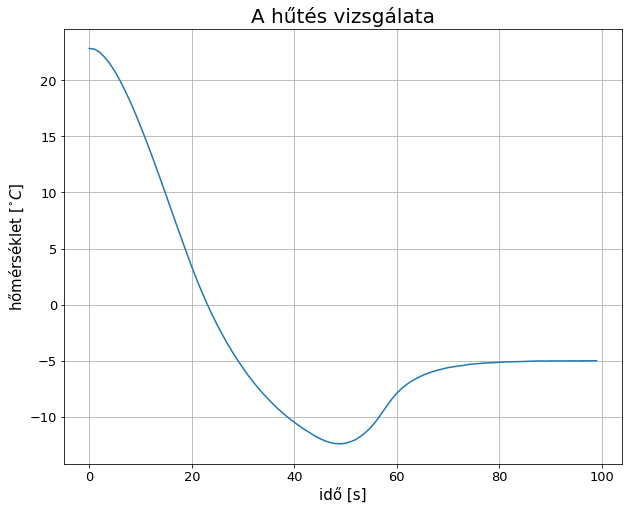

In [34]:
# ábra
plot(idocool,cooldata)
xlabel("idő [s]", size = 15)
ylabel(r"hőmérséklet [$^{\circ} C$]", size = 15)
title("A hűtés vizsgálata", size = 20)
xticks(size = 13)
yticks(size = 13)
grid()

In [35]:
# válaszok
diff = cooldata[1:]-cooldata[:-1]

In [38]:
diff

array([-0.05652726, -0.26761224, -0.46136775, -0.56734833, -0.69705701,
       -0.82179089, -0.9148731 , -0.96505635, -1.06412993, -1.12137736,
       -1.16429558, -1.19403315, -1.24735701, -1.26449531, -1.28247976,
       -1.31294298, -1.28758685, -1.26483702, -1.26681445, -1.2372774 ,
       -1.17671431, -1.08512722, -1.05057733, -0.97299295, -0.91838649,
       -0.86435165, -0.79953265, -0.76820328, -0.71467217, -0.66098394,
       -0.65207884, -0.58679378, -0.55501383, -0.53441964, -0.46797051,
       -0.4697388 , -0.4370439 , -0.39248246, -0.38230769, -0.34877521,
       -0.32661746, -0.31599051, -0.28176535, -0.28262488, -0.24802233,
       -0.20128874, -0.14236585, -0.09504109, -0.02377673,  0.04754687,
        0.14248309,  0.18961462,  0.30725848,  0.3649877 ,  0.4454658 ,
        0.54815901,  0.6377477 ,  0.6570038 ,  0.63044189,  0.52483118,
        0.45469102,  0.36269535,  0.30533321,  0.24834434,  0.22543471,
        0.18012773,  0.15745646,  0.1348505 ,  0.11229823,  0.11

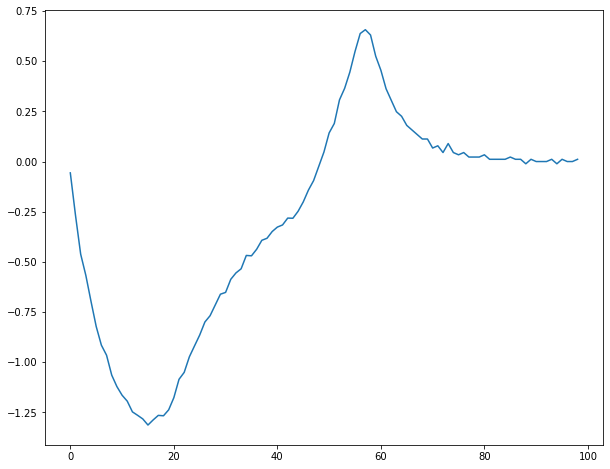

In [37]:
plot(diff)

### 1. c) - 5 pont

Kapcsolja ki a termosztátot, és mérje ki a detektor melegedési görbéjét. Milyen időállandóval történik a melegedés?

In [25]:
# mérés
def heat(minta):
    T=[]
    t=linspace(0,minta-1,minta)
    st5.reset_temperature()
    for i in range(minta):
        T.append(st5.get_temperature())
        time.sleep(1)
    T=array(T)
    return t,T

idoheat , heatdata = heat(150)

In [39]:
#savetxt("heat.txt", heatdata)
with open('heat.txt', 'r') as file:
    
    result = file.read()
    result = result.split("\n")

result = [float(element) for element in result if element]
heatdata = array(result)
idoheat = np.linspace(0,149,150)

In [43]:
def expmodel(t,a,b,T):
    return -a*exp(-t/T) + b  

In [46]:
from scipy.optimize import curve_fit

In [54]:
popt,pcov = curve_fit(expmodel,idoheat[10:],heatdata[10:])
perr = sqrt(diag(pcov))

In [62]:
print(popt)
print(perr)

[38.2162596  23.25082019 19.86026074]
[0.14757866 0.01579918 0.08427743]


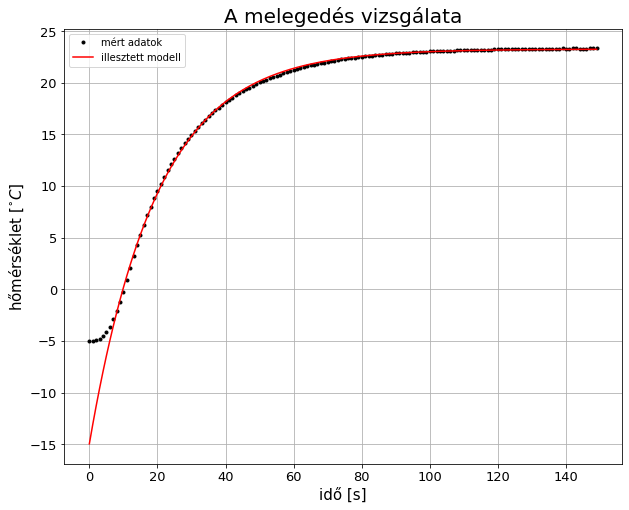

In [61]:
# ábra
plot(idoheat,heatdata,"ro" ,label = "mért adatok", ms = 3, color="black")
plot(idoheat,expmodel(idoheat,*popt), label = "illesztett modell", color = "red")
xlabel("idő [s]", size = 15)
ylabel(r"hőmérséklet [$^{\circ} C$]", size = 15)
title("A melegedés vizsgálata", size = 20)
xticks(size = 13)
yticks(size = 13)
grid()
legend()

In [ ]:
# időállandó meghatározása

## 2. feladat: CCD termikus zajának és forró pixeleinek vizsgálata

A CCD-detektor termikus tulajdonságainak vizsgálatához és az ún. *dark* képek elkészítéséhez zárja le a kamera nyílását. Felvételt az `st5.take_image(cs)` függvény segítségével készíthet, ahol a `cs` paraméter az expozíciós időt jelenti századmásodpercben. Az elkészült képet az `st5.read_image()` függvény segítsével lehet a vezérlőegységről letölteni. A detektor hőmérsékletét az `st5.get_temperature()` függvénnyel lehet kiolvasni.

### 2. a) - 2 pont

A termosztát kikapcsolt állapota mellett zárja le a kamera nyílását és készítsen egy néhány másodperc expozíciós idejű felvételt. Jegyezze fel az expozíciós időt, és a detektor hőmérsékletét! Az elkészült képet az `imshow(img, cmap='gray')` függvény segítségével szürkeárnyalatos képként ábrázolhatja. Az ábrázolási tartomány az `imshow` függvény `vmin` és `vmax` paramétereivel állítható be.

In [52]:
# mérés
def picture(másodperc):
    st5.reset_temperature()
    T = []
    t = linspace(0,másodperc,másodperc*5)
    st5.take_image(másodperc*100)
    for i in range(másodperc):
        T.append(st5.get_temperature())
        time.sleep(0.2)
    picture = st5.read_image()
    T = array(T)
    return t,T,picture
       
    
idokep,idohom, kep = picture(5)    

In [64]:
with open('idohom.txt', 'r') as file:
    
    result = file.read()
    result = result.split("\n")

result = [float(element) for element in result if element]
idohom = array(result)

In [66]:
idohom.mean()

23.229517303938472

In [53]:
#savetxt("idokep.txt", idokep)
#savetxt("idohom.txt", idohom)
#savetxt("kep.txt", kep)

In [ ]:
kepjo = imsave(kep)

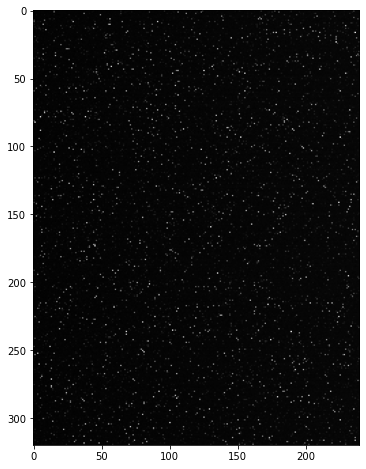

In [54]:
# kép ábrázolása
imshow(kep, cmap = "gray")

### 2. b) - 3 pont

Készítse el az előző feladatban felvett kép pixelintezitás-hisztogramját! Ábrázolja a hisztogramot úgy, hogy a termikus zaj, illetve a forró pixelek is látszódjanak! Határozza meg a pixelek átlagos értékét és a zaj mértékét. Végezze el a számítást a forró pixelek kiszűrésével is! A tengelyek skálázásánál ügyeljen arra, hogy a kamera A/D konvertere 14 bites.

In [55]:
# hisztogram elkészítése

In [19]:
file_path = "kep.txt"  
with open(file_path, 'r') as file:
        lines = file.readlines()
        data_array = []

        for line in lines:
            values = [float(value) for value in line.strip().split()]
            data_array.extend(values)
 

In [31]:
data_array = array(data_array)

In [32]:
skalazott_kep = ((data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array)) * 255).astype(np.uint8)

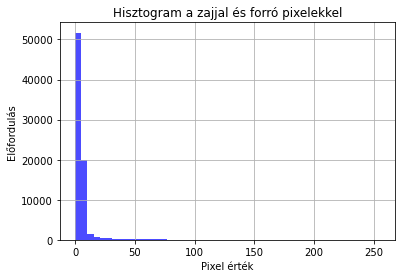

In [33]:
plt.hist(skalazott_kep, bins=50, color='blue', alpha=0.7)
plt.title('Hisztogram a zajjal és forró pixelekkel')
plt.xlabel('Pixel érték')
plt.ylabel('Előfordulás')
plt.grid(True)
plt.show()

In [34]:
skalazott_kep.mean()

7.411731770833334

In [ ]:
# hisztogram ábra

In [ ]:
# átlagos érték és zaj

In [35]:
zaj = np.sqrt(skalazott_kep.var() / len(skalazott_kep))

In [36]:
print(zaj)

0.055493584323608264


In [40]:
nohotpix = np.where(skalazott_kep <= 10)

In [47]:
nohotpix = skalazott_kep[nohotpix]

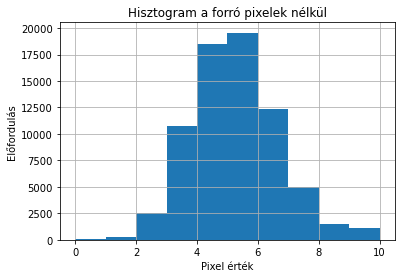

In [51]:
plt.hist(nohotpix)
plt.title('Hisztogram a forró pixelek nélkül')
plt.xlabel('Pixel érték')
plt.ylabel('Előfordulás')
plt.grid(True)
plt.show()

In [52]:
nohotpix.mean()

4.762587017480225

In [54]:
zaj = np.sqrt(nohotpix.var() / len(nohotpix))

In [55]:
zaj

0.005474217471714881

### 2. c) - 5 pont

Ismételje meg az előző mérést különböző expozíciós időkkel, illetve a kamera termosztátjának különböző beállításai mellett. Ügyeljen arra, hogy a termosztátnak jelentős időbe telik, mire stabilizálja a detektor hőmérsékletét! A hőmérsékletet érdemes 15 °C körüli értékről indulva folyamatosan csökkenteni. Rajzolja fel a képeket, és ábrázolja a hisztogrammokat. Határozza meg az egyes képek zaját. Hogyan függ a pixelek zaja a hőmérséklettől és az expozíciós időtől? 

In [ ]:
# mérés

In [70]:
x = np.linspace(15,-5,10)
x2 = []
for item in x:
    x2.append(int(item))
    

In [81]:
def morepicture(másodperc): #különböző hőmérsékletek
    for i in x2:
        st5.set_temperature(i)
        time.sleep(15)
        T = []
        t = linspace(0,másodperc,másodperc*5)
        st5.take_image(másodperc*100)
        for j in range(másodperc):
            T.append(st5.get_temperature())
            time.sleep(0.2)
        picture = st5.read_image()
        T = array(T)
        savetxt(f"idokep{i}-2c.txt", t)
        savetxt(f"idohom{i}-2c.txt", T)
        imsave(f"kep{i}-2c.png", picture)
    return "done"
       

In [82]:
morepicture(4)

'done'

In [281]:
x = imread("2chőm/kep-2-2c.png")

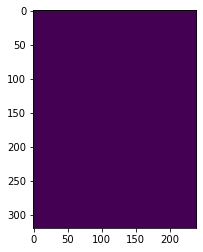

In [178]:
imshow(x[:,:,3])

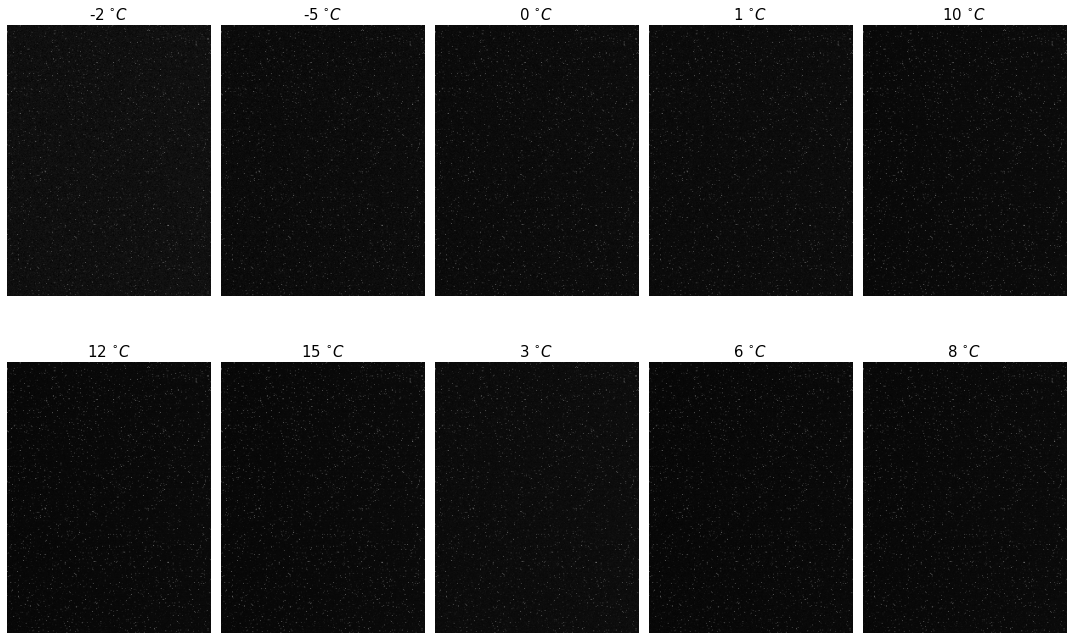

In [206]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread


directory_path = '2chőm'


png_files = [file for file in os.listdir(directory_path) if file.endswith('.png')]

temperatures = [-2, -5, 0, 1, 10, 12, 15, 3, 6, 8]


num_files = len(png_files)
num_cols = 5
num_rows = -(-num_files // num_cols)  
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))


for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        if index < num_files:
            image_path = os.path.join(directory_path, png_files[index])
            image = imread(image_path)
            image = image[:,:,0] + image [:,:,1] + image [:,:,2] # negyedik réteget kiszedtem, mert miatta hibásan működött a cmap paraméter
            axes[i, j].imshow(image, cmap="gray")
            axes[i, j].axis('off') 
            axes[i, j].set_title(f"{temperatures[index]} $^{{\circ}}C$", size = 15)

for i in range(num_files, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])
plt.tight_layout()




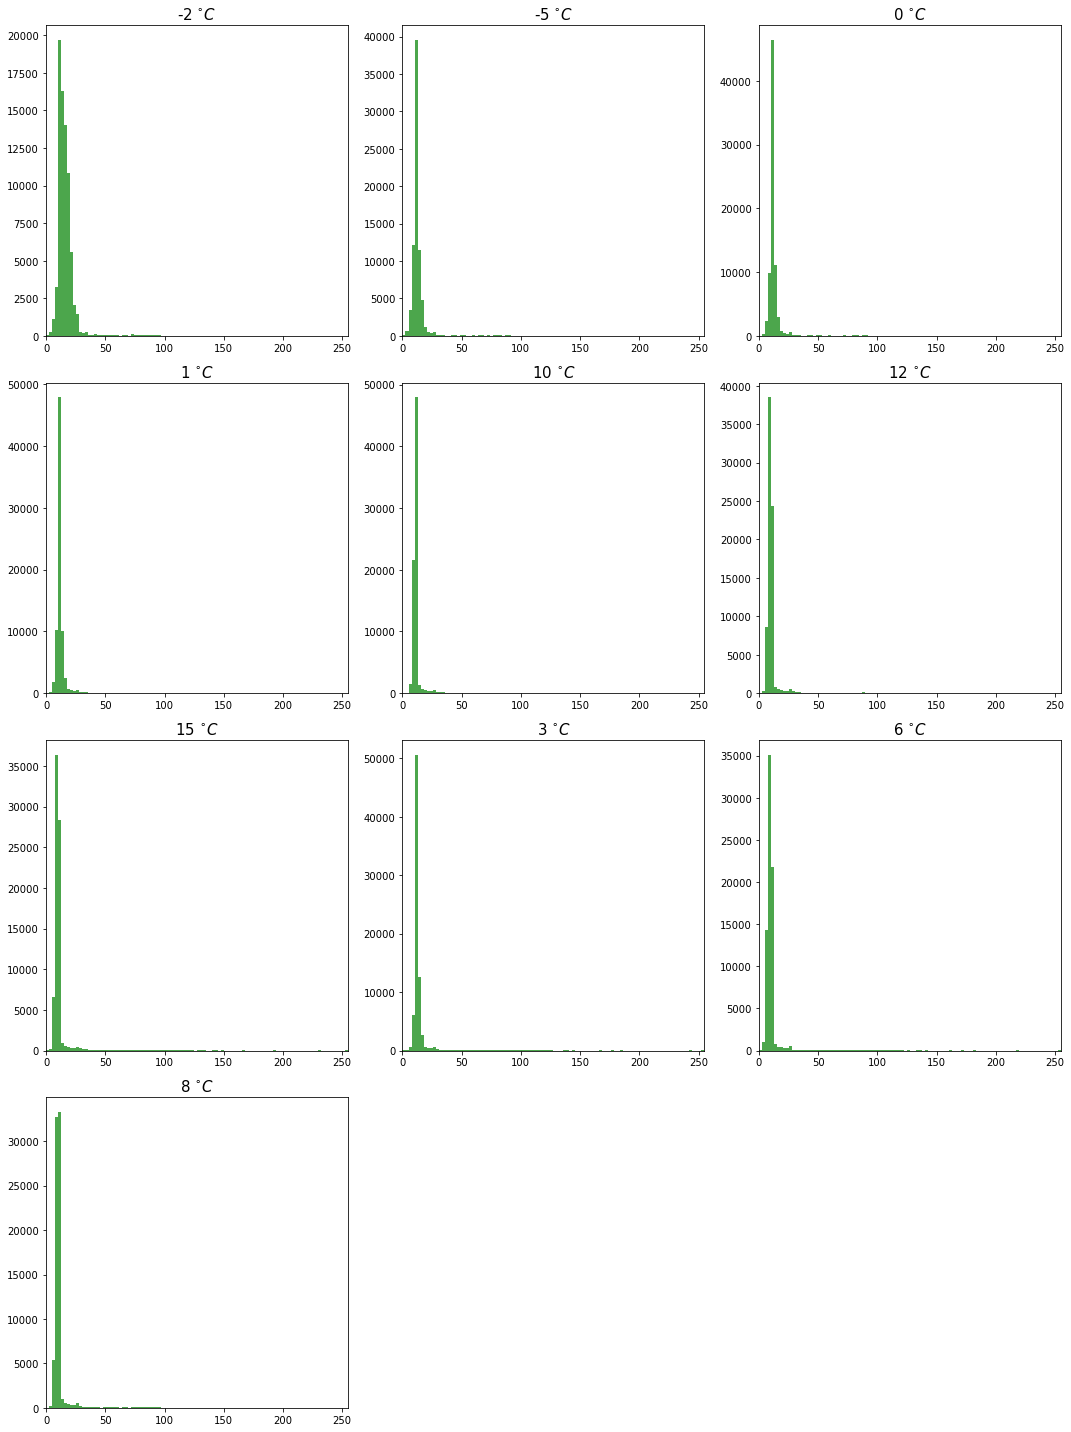

In [202]:
import os

zaj = []
directory_path = '2chőm'
png_files = [file for file in os.listdir(directory_path) if file.endswith('.png')]

temperatures = [-2, -5, 0, 1, 10, 12, 15, 3, 6, 8]

num_files = len(png_files)
num_cols = 3
num_rows = -(-num_files // num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i in range(num_rows):
    for j in range(num_cols):
        
        index = i * num_cols + j
        
        if index < num_files:
            
            image_path = os.path.join(directory_path, png_files[index])
            image = imread(image_path)
            image = image[:,:,0] + image [:,:,1] + image [:,:,2]
            
            rescaled_data = ((image - np.min(image)) /
                             (np.max(image) - np.min(image)) * 255).astype(float)
            zaj.append(np.sqrt(rescaled_data.var() / len(rescaled_data)))
            
            axes[i, j].hist(rescaled_data.flatten(), bins=100, color='green', alpha=0.7)
            axes[i, j].set_title(f"{temperatures[index]} $^{{\circ}}C$" , size = 15)
            axes[i, j].set_xlim([0, 255])


for i in range(num_files, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()




In [204]:
combined_data = list(zip(temperatures, zaj))


sorted_data = sorted(combined_data, key=lambda x: x[0])


sorted_temperatures, sorted_zaj = zip(*sorted_data)


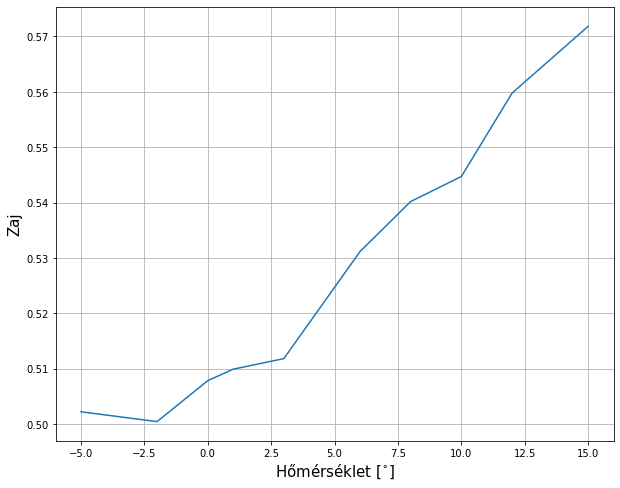

In [210]:
figsize(10,8)
plot(sorted_temperatures,sorted_zaj)
xlabel(r"Hőmérséklet [$^{\circ}$]", size = 15)
ylabel(r"Zaj", size = 15)
grid(True)

In [88]:
times = np.linspace(3,10,7)
times2 = []
for item in times:
    times2.append(int(item))

In [89]:

def timemodkep(temp):
    st5.set_temperature(temp)
    time.sleep(30)
    for másodperc in times2:
        T = []
        t = linspace(0,másodperc,másodperc*5)
        st5.take_image(másodperc*100)
        for j in range(másodperc):
            T.append(st5.get_temperature())
            time.sleep(0.2)
        picture = st5.read_image()
        T = array(T)
        savetxt(f"idokep{másodperc}-2cido.txt", t)
        savetxt(f"idohom{másodperc}-2cido.txt", T)
        imsave(f"kep{másodperc}-2cido.png", picture)
    return "done"
        

In [90]:
timemodkep(5)

'done'

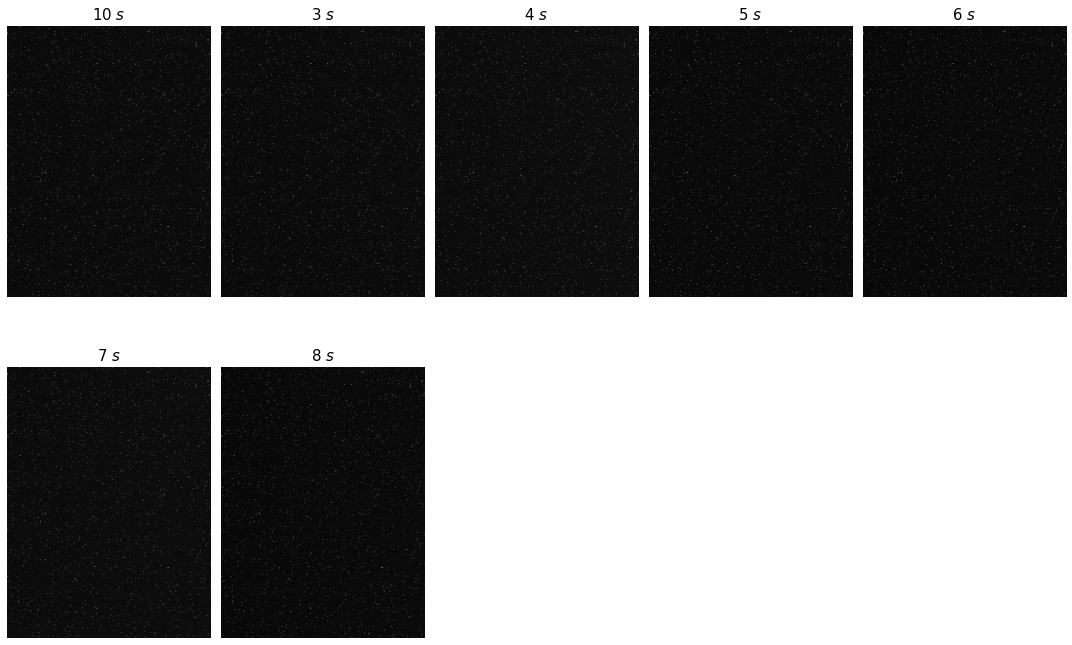

In [219]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread


directory_path = '2cidő'


png_files = [file for file in os.listdir(directory_path) if file.endswith('.png')]


times = [10,3,4,5,6,7,8]


num_files = len(png_files)
num_cols = 5
num_rows = -(-num_files // num_cols)  
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))


for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        if index < num_files:
            image_path = os.path.join(directory_path, png_files[index])
            image = imread(image_path)
            image = image[:,:,0] + image [:,:,1] + image [:,:,2] 
        
            axes[i, j].imshow(image, cmap="gray")
            axes[i, j].axis('off')  
            axes[i, j].set_title(f"{times[index]} $s$", size = 15)


for i in range(num_files, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])
plt.tight_layout()




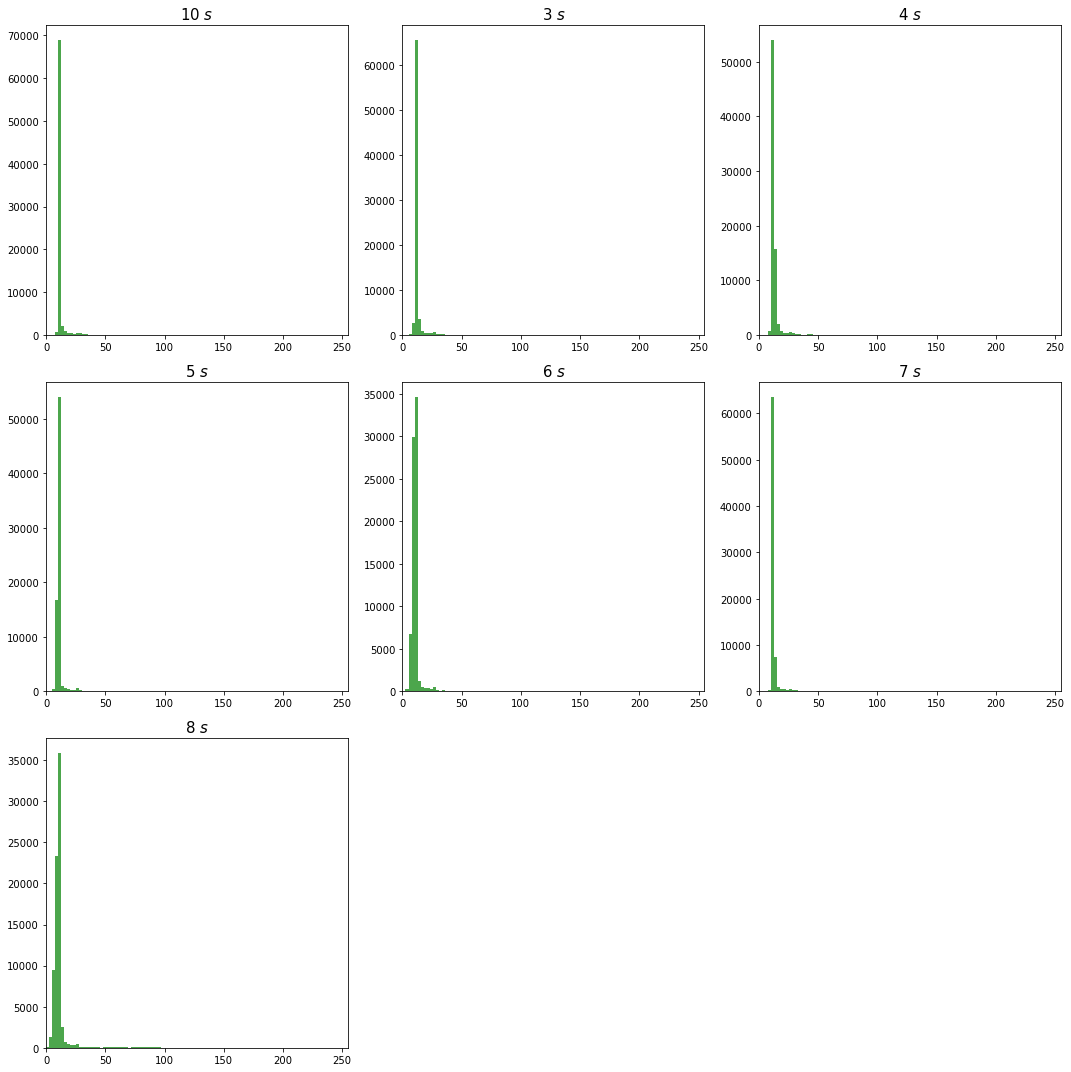

In [220]:
import os


zaj = []
directory_path = '2cidő'
png_files = [file for file in os.listdir(directory_path) if file.endswith('.png')]

times = [10,3,4,5,6,7,8]


num_files = len(png_files)
num_cols = 3
num_rows = -(-num_files // num_cols)  


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i in range(num_rows):
    for j in range(num_cols):
        
        index = i * num_cols + j

        
        if index < num_files:
            
            image_path = os.path.join(directory_path, png_files[index])
            image = imread(image_path)
            image = image[:,:,0] + image [:,:,1] + image [:,:,2]
            
      

            
            rescaled_data = ((image - np.min(image)) /
                             (np.max(image) - np.min(image)) * 255).astype(float)
            zaj.append(np.sqrt(rescaled_data.var() / len(rescaled_data)))
            
            axes[i, j].hist(rescaled_data.flatten(), bins=100, color='green', alpha=0.7)
            axes[i, j].set_title(f"{times[index]} $s$" , size = 15)
            axes[i, j].set_xlim([0, 255])


for i in range(num_files, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()




In [221]:
combined_data = list(zip(times, zaj))


sorted_data = sorted(combined_data, key=lambda x: x[0])


sorted_times, sorted_zaj = zip(*sorted_data)


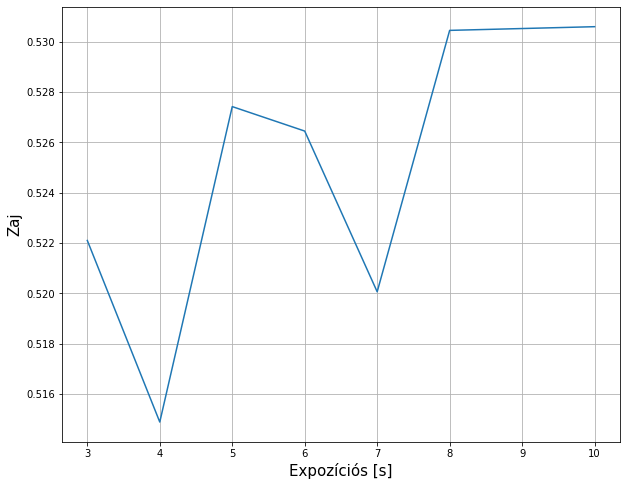

In [223]:
plot(sorted_times,sorted_zaj)
xlabel(r"Expozíciós [s]", size = 15)
ylabel(r"Zaj", size = 15)
grid(True)

In [ ]:
imshow(proba[:,:,1], cmap  = "gray")

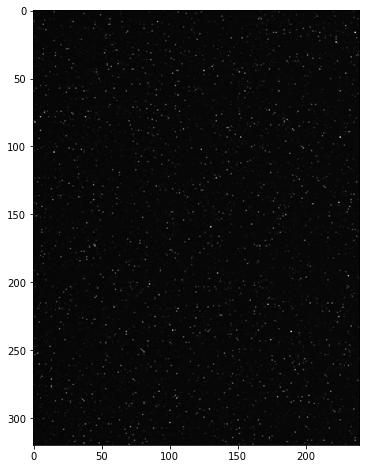

In [111]:
imshow(proba1[:,:,1], cmap  = "gray")

## 3. feladat - kalibrált szürkeárnyalatos felvétel készítése

### 3. a) - 4 pont

Állítsa a szűrőváltot szűrő nélküli állásba és válasszon minimális (f/22) blendenyílást. Hűtse le a detektort -10 fokra, majd készítsen egy képet a méréshez tartozó apró bábuk valamelyikéről. Válasszon olyan expozíciós időt, hogy kihasználja a detektor dinamikatartományát, ugyanakkor a pixelek ne szaturálódjanak. Ha szükséges, a laborvezető segítségével állítson a fókuszon. Rajzolja fel a képet is az intenzitáshisztogramot!

A továbbiakban úgy nevezze el a változókat, hogy az összes elkészült kép a memóriában maradjon, mert szükség lesz rájuk. A képeket tartalmazó tömböket az `np.save` függvénnyel bináris fájlokba is mentse el!

In [ ]:
# hőmérséklet beállítása

In [113]:
st5.set_temperature(-10)

In [114]:
st5.get_temperature()

-6.048995413044281

In [ ]:
# expozíció

In [115]:
st5.take_image(50)
baba = st5.read_image()
imsave("figura.png",baba)

NameError: name 'figura' is not defined

In [116]:
imsave("figura.png",baba)

In [ ]:
# kép felrajzolása

In [251]:
baba = imread("figura.png")

In [273]:
baba = baba[:,:,0]+baba[:,:,1] + baba[:,:,2]

In [274]:
rescaled_data = ((baba - np.min(baba)) /
                             (np.max(baba) - np.min(baba)) * 255).astype(int)

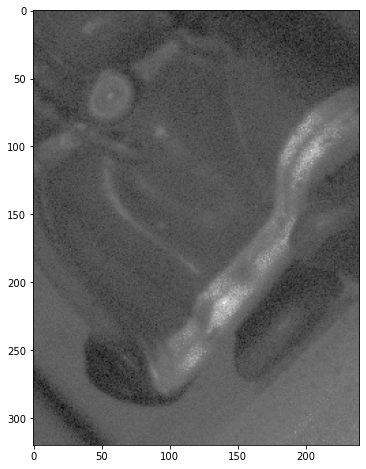

In [275]:
imshow(rescaled_data, cmap = "gray")

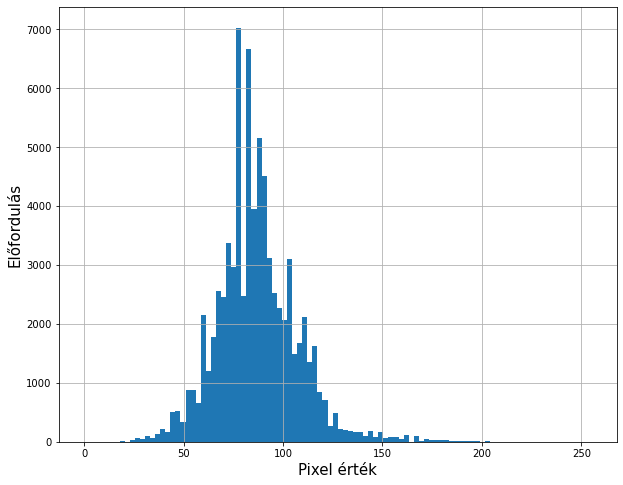

In [279]:
plt.hist(rescaled_data.flatten(),bins = 100)
plt.xlabel('Pixel érték',size = 15)
plt.ylabel('Előfordulás',size=15)
plt.grid(True)
plt.show()

### 3. b) Flat kép készítése - 3 pont

Helyezzen egy papírlapot a kamera elé, és a 3. a) feladatban használt expozíciós idő és hőmérséklet mellett készítsen legalább 5 fókuszálatlan felvételt az egyenletesen megvilágított papírlapról. (Egyenként töltse le a képeket, hogy a kameraprocesszor belső buffere nehogy túlcsorduljon!) Átlagolja ki a képeket, majd ábrázolja!

In [126]:
st5.take_image(50)
aktimage = st5.read_image()
imsave("flat5.png",aktimage)

In [ ]:
# átlagolás

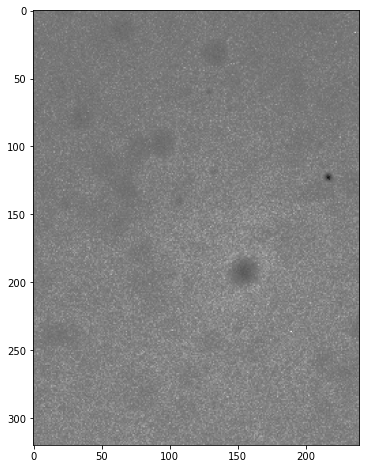

In [293]:
flat1 = imread("flat1.png")
flat2 = imread("flat1.png")
flat3 = imread("flat1.png")
flat5 = imread("flat1.png")
y1 = flat1[:,:,0]+flat1[:,:,1]+flat1[:,:,2]
y2 = flat2[:,:,0]+flat2[:,:,1]+flat2[:,:,2]
y3 = flat3[:,:,0]+flat3[:,:,1]+flat3[:,:,2]
y5 = flat5[:,:,0]+flat5[:,:,1]+flat5[:,:,2]

mean = (y1+y2+y3+y5)/4

imshow(mean,cmap ="gray")


### 3. c) - Dark kép készítése - 2 pont

Az előző kép még nyers, a detektor sötétáramát is tartalmazza. Ismét takarja el az objektív nyílását, és készítsen _dark_ felvételeket az előzővel megegyező expozíciós idővel és detektorhőmérséklettel. Átlagoljon ki legalább 10 képet. Erre használhatja a kameraprocesszor belső bufferét az alábbi rövid script segítségével:

In [127]:
# Dark kép rögzítése

N = 10
st5.clr_buf(sbigpy.ST5.BUFFER_ACCU)
for i in range(N):
    st5.take_image(50)#ez volt nekem is a exp idő, hőmérsékletet nem változtattam
    st5.accum_image()
dark = st5.read_image(buffer=sbigpy.ST5.BUFFER_ACCU)
dark = dark / N

In [128]:
imsave("dark.png",dark)

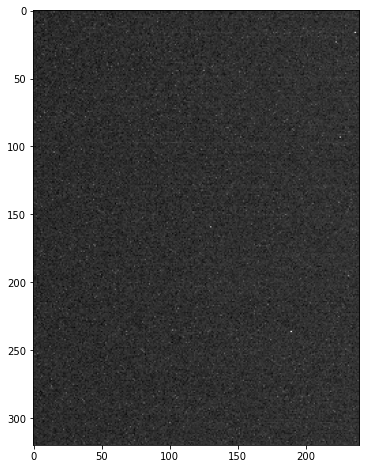

In [302]:
d = imread("dark.png")
d = d[:,:,0]+d[:,:,1]+d[:,:,2]
imshow(d,cmap="gray")

In [300]:
rescaled_data = ((d - np.min(d)) /
                             (np.max(d) - np.min(d)) * 255).astype(int)

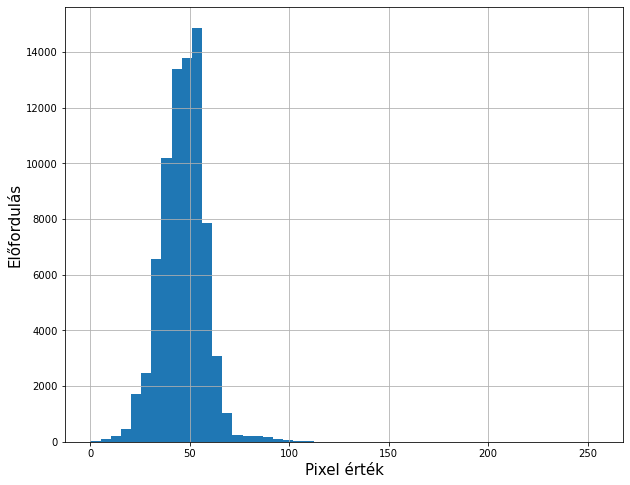

In [308]:
plt.hist(rescaled_data.flatten(), bins = 50)
plt.xlabel('Pixel érték',size = 15)
plt.ylabel('Előfordulás',size=15)
plt.grid(True)
plt.show()

### 3. d) - Bias kép készítése - 2 pont

Az előző feladathoz hasonlóan, eltakart detektorállás mellett készítsen _bias_ felvételeket, melyből a detektor pixeleinek nullponti értékei határozhatók meg. A felvételeket minimális, 1/100 másodperces idővel készítse.

In [132]:
# Bias kép rögzítése

N = 10
st5.clr_buf(sbigpy.ST5.BUFFER_ACCU)
for i in range(N):
    st5.take_image(1)
    st5.accum_image()
bias = st5.read_image(buffer=sbigpy.ST5.BUFFER_ACCU)
bias = bias / N

In [ ]:
# kép felrajzolása

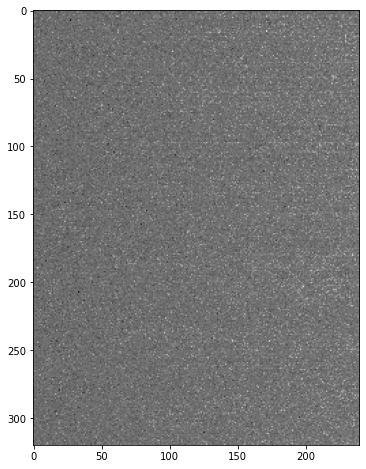

In [309]:
d = imread("bias.png")
d = d[:,:,0]+d[:,:,1]+d[:,:,2]
imshow(d,cmap="gray")

In [134]:
imsave("bias.png",bias)

In [ ]:
# hisztogram

In [310]:
rescaled_data = ((d - np.min(d)) /
                             (np.max(d) - np.min(d)) * 255).astype(int)

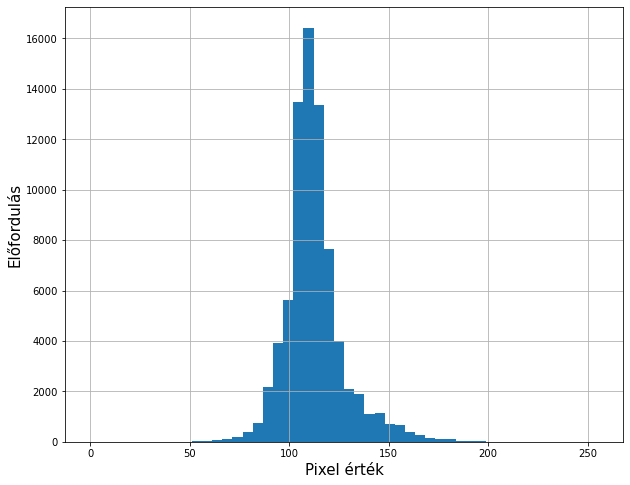

In [311]:
plt.hist(rescaled_data.flatten(), bins = 50)
plt.xlabel('Pixel érték',size = 15)
plt.ylabel('Előfordulás',size=15)
plt.grid(True)
plt.show()

In [ ]:
# tapasztalatok

### 3. e) Kép kalibrálása - 3 pont

Az $I = \frac{R - D}{F}$ formula alapján készítse el és ábrázolja a kalibrált képet. Hasonlítsa össze az eredetivel, és elemezze a tapasztalatokat!

In [ ]:
# számolás

In [312]:
I=(baba-d)/mean

In [ ]:
# ábrázolás

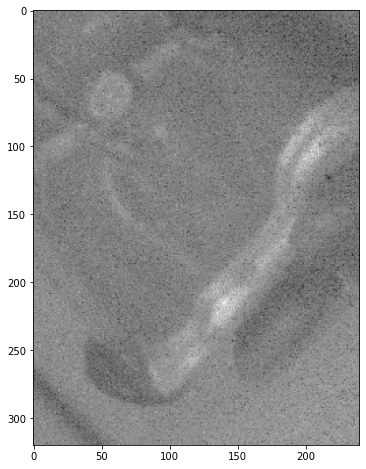

In [314]:
imshow(I,cmap = "gray")

In [315]:
# hisztogram
rescaled_data = ((I - np.min(I)) /
                             (np.max(I) - np.min(I)) * 255).astype(int)

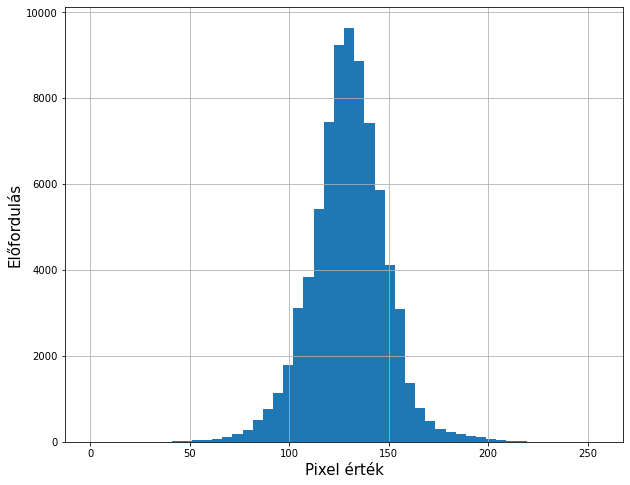

In [316]:
plt.hist(rescaled_data.flatten(), bins = 50)
plt.xlabel('Pixel érték',size = 15)
plt.ylabel('Előfordulás',size=15)
plt.grid(True)
plt.show()

## 4. feladat - színes felvétel készítése

### 4. a) - 3 pont

Készítsen a báburól egy-egy felvételt a három színszűrővel. Ügyeljen arra, hogy két expozíció között se a kamera, se a modell ne mozduljon el. Az előző feladatban megismert módon kalibrálja a képeket. Mindhárom színszűrő esetében használhatja a szűrő nélküli _flat_ képeket.

In [140]:
# felvételek elkészítése

#piros
st5.take_image(50)
babapiros = st5.read_image()
imsave("figurapiros.png",babapiros)

In [143]:
#kék
st5.take_image(50)
babakek = st5.read_image()
imsave("figurakek.png",babakek)

In [145]:
#zöld
st5.take_image(50)
babazöld = st5.read_image()
imsave("figurazöld.png",babazöld)

In [ ]:
# kalibráció

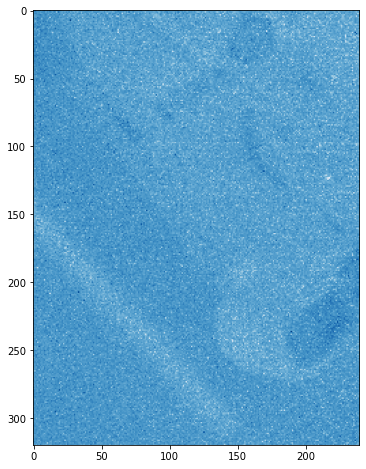

In [325]:
kek = imread("figurakek.png")
kek = kek[:,:,0] + kek[:,:,1] +kek[:,:,2]  
kek = (kek-d)/mean
imshow(kek,cmap = "Blues")

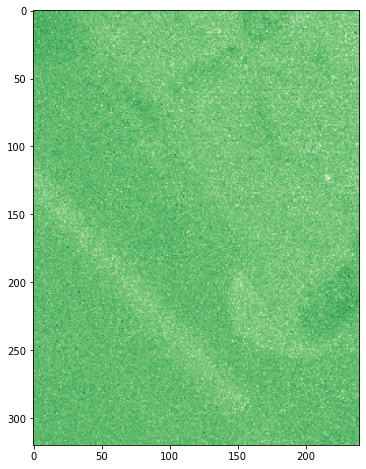

In [326]:
zold = imread("figurazöld.png")
zold = zold[:,:,0] + zold[:,:,1] +zold[:,:,2]  
zold = (zold-d)/mean
imshow(zold,cmap = "Greens")

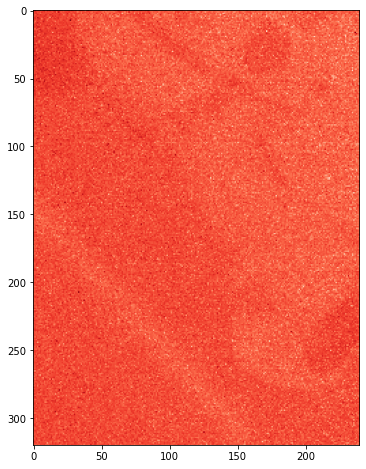

In [327]:
piros = imread("figurapiros.png")
piros = piros[:,:,0] + piros[:,:,1] + piros[:,:,2] 
piros = (piros-d)/mean
imshow(piros,cmap = "Reds")

In [ ]:
# a három színcsatorna ábrázolása külön-külön

### 4. b) - 3 pont

Kombinálja össze a három színcsatornát színes RGB képpé! Ábrázolja a képet! Ügyeljen arra, hogy az `imshow` függvény csak `uint8` típusú tömbökben tárolt színes képeket tud megjeleníteni. Elemezze a tapasztalatait. Milyen módon lehet meghatározni a három színcsatorna helyes keverési arányát?

In [ ]:
# számolás

In [340]:
c=(piros+zold+kek)/3

In [341]:
# ábrázolás

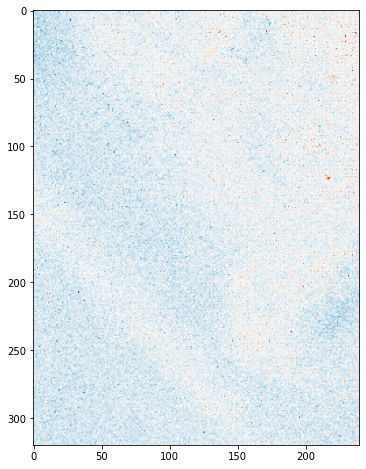

In [342]:
imshow(c,cmap = "RdBu")

In [ ]:
# tapasztalatok